<img align="left" src="https://lever-client-logos.s3.amazonaws.com/864372b1-534c-480e-acd5-9711f850815c-1524247202159.png" width=200>
<br></br>
<br></br>

# Natural Language Processing (NLP)
## *Data Science Unit 4 Sprint 1 Assignment 1*

Your goal in this assignment: find the attributes of the best & worst coffee shops in the dataset. The text is fairly raw: dates in the review, extra words in the `star_rating` column, etc. You'll probably want to clean that stuff up for a better analysis. 

Analyze the corpus of text using text visualizations of token frequency. Try cleaning the data as much as possible. Try the following techniques: 
- Lemmatization
- Custom stopword removal

Keep in mind the attributes of good tokens. Once you have a solid baseline, layer in the star rating in your visualization(s). Key part of this assignment - produce a write-up of the attributes of the best and worst coffee shops. Based on your analysis, what makes the best the best and the worst the worst. Use graphs and numbesr from your analysis to support your conclusions. There should be plenty of markdown cells! :coffee:

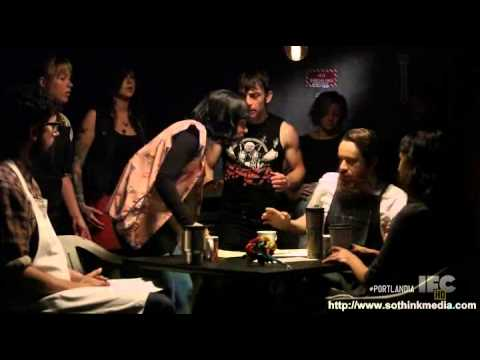

In [5]:
from IPython.display import YouTubeVideo

YouTubeVideo('Jml7NVYm8cs')

In [78]:
%pwd

'C:\\Users\\doina\\OneDrive\\Desktop\\Lambda-School\\4_Machine-Learning\\DS-Unit-4-Sprint-1-NLP\\module1-text-data'

In [79]:
import pandas as pd

url = "https://raw.githubusercontent.com/LambdaSchool/DS-Unit-4-Sprint-1-NLP/master/module1-text-data/data/yelp_coffeeshop_review_data.csv"

shops = pd.read_csv(url)
shops.head()

,coffee_shop_name,full_review_text,star_rating
0,The Factory - Cafe With a Soul,11/25/2016 1 check-in Love love loved the atm...,5.0 star rating
1,The Factory - Cafe With a Soul,"12/2/2016 Listed in Date Night: Austin, Ambia...",4.0 star rating
2,The Factory - Cafe With a Soul,11/30/2016 1 check-in Listed in Brunch Spots ...,4.0 star rating
3,The Factory - Cafe With a Soul,11/25/2016 Very cool decor! Good drinks Nice ...,2.0 star rating
4,The Factory - Cafe With a Soul,12/3/2016 1 check-in They are located within ...,4.0 star rating


## Data Cleaning

In [80]:
# Remove date from 'full_review_text'
reviews = shops['full_review_text'].tolist()
shops['full_review_text'] = [s.split(None, 1)[-1] for s in reviews]
shops['full_review_text']

0       1 check-in Love love loved the atmosphere! Eve...
1       Listed in Date Night: Austin, Ambiance in Aust...
2       1 check-in Listed in Brunch Spots I loved the ...
3       Very cool decor! Good drinks Nice seating  How...
4       1 check-in They are located within the Northcr...
                              ...                        
7611    I actually step into this restaurant by chance...
7612    Ok, The Steeping Room IS awesome. How do they ...
7613    Loved coming here for tea, and the atmosphere ...
7614    The food is just average. The booths didn't fe...
7615    I finally stopped in for lunch with my colleag...
Name: full_review_text, Length: 7616, dtype: object

In [81]:
# Remove text from 'star_rating'
shops['star_rating'] = shops['star_rating'].str.replace(r"[a-zA-Z]",'')
shops['star_rating'].head()

0     5.0   
1     4.0   
2     4.0   
3     2.0   
4     4.0   
Name: star_rating, dtype: object

In [82]:
# Convert values from string into float
shops['star_rating'] = shops['star_rating'].astype(float)
shops['star_rating'].dtypes

dtype('float64')

## How do we want to analyze these coffee shop tokens? 

- Overall Word / Token Count
- View Counts by Rating 
- *Hint:* a 'bad' coffee shops has a rating betweeen 1 & 3 based on the distribution of ratings. A 'good' coffee shop is a 4 or 5. 

# Custom stopword removal
## Overall Word / Token Count

In [83]:
# Define a function to parse the strings into a list of words
import re
def tokenize(text):
    tokens = re.sub(r'[^a-zA-Z ^0-9]', '', text)
    tokens = tokens.lower().split()
    return tokens

In [84]:
# Tokenize the 'full_review_text'
shops['tokens'] = shops['full_review_text'].apply(tokenize)
shops['tokens'].head()

0    [1, checkin, love, love, loved, the, atmospher...
1    [listed, in, date, night, austin, ambiance, in...
2    [1, checkin, listed, in, brunch, spots, i, lov...
3    [very, cool, decor, good, drinks, nice, seatin...
4    [1, checkin, they, are, located, within, the, ...
Name: tokens, dtype: object

In [85]:
# Analyze tokens
from collections import Counter

# Instaniate an empty object `Counter`
word_counts = Counter()

# Update it based on a split of each of the documents
shops['tokens'].apply(lambda x: word_counts.update(x))

# Print out the 10 most common words
word_counts.most_common(10)

[('the', 34809),
 ('and', 26650),
 ('a', 22755),
 ('i', 20237),
 ('to', 17164),
 ('of', 12600),
 ('is', 11999),
 ('coffee', 10353),
 ('was', 9707),
 ('in', 9546)]

In [86]:
# create a fuction which takes a corpus of document and returns and dataframe of word counts
def count(docs):
    
        # Instanstiate the Counter object
        word_counts = Counter()
        
        # Get the total number of words
        total_docs = len(docs)
        
        # Update the counter object
        for doc in docs:
            word_counts.update(doc)
        
        # Create a word count dataframe
        temp = zip(word_counts.keys(), word_counts.values())
        wc = pd.DataFrame(temp, columns = ['word', 'count'])
        
        # Get the rank of the word
        wc['rank'] = wc['count'].rank(method='first', ascending=False)
        
        # Get the total number of words
        total = wc['count'].sum()
        
        # Get the relative percentage of the word
        wc['pct_total'] = wc['count'].apply(lambda x: x / total)
        wc = wc.sort_values(by='rank')
        return wc

In [87]:
# Use the function
wc = count(shops['tokens'])
wc.head()

,word,count,rank,pct_total
4,the,34809,1.0,0.044975
15,and,26650,2.0,0.034433
49,a,22755,3.0,0.029401
19,i,20237,4.0,0.026147
44,to,17164,5.0,0.022177


In [88]:
# Processing Raw Text with Spacy
import spacy
from spacy.tokenizer import Tokenizer
nlp = spacy.load("en_core_web_lg")

# Tokenizer
tokenizer = Tokenizer(nlp.vocab)

In [89]:
# Tokenizer Pipe

tokens = []

for doc in tokenizer.pipe(shops['full_review_text'], batch_size=500):
    doc_tokens = [token.text for token in doc]
    tokens.append(doc_tokens)

shops['tokens'] = tokens
shops['tokens'].head()

0    [1, check-in, Love, love, loved, the, atmosphe...
1    [Listed, in, Date, Night:, Austin,, Ambiance, ...
2    [1, check-in, Listed, in, Brunch, Spots, I, lo...
3    [Very, cool, decor!, Good, drinks, Nice, seati...
4    [1, check-in, They, are, located, within, the,...
Name: tokens, dtype: object

In [90]:
# Count
wc = count(shops['tokens'])
wc.head()

,word,count,rank,pct_total
5,the,27779,1.0,0.034993
16,and,25748,2.0,0.032434
50,a,22085,3.0,0.027820
20,I,19780,4.0,0.024916
45,to,16904,5.0,0.021294


In [91]:
# The most common words are still Stop Words
# Update the tokens without stop words
tokens = []
for doc in tokenizer.pipe(shops['full_review_text'], batch_size=500):
    doc_tokens = []
    for token in doc:
        if (token.is_stop == False) & (token.is_punct == False):
            doc_tokens.append(token.text.lower())
    tokens.append(doc_tokens)

shops['tokens'] = tokens
shops['tokens'].head()

0    [1, check-in, love, love, loved, atmosphere!, ...
1    [listed, date, night:, austin,, ambiance, aust...
2    [1, check-in, listed, brunch, spots, loved, ec...
3    [cool, decor!, good, drinks, nice, seating,  ,...
4    [1, check-in, located, northcross, mall, shopp...
Name: tokens, dtype: object

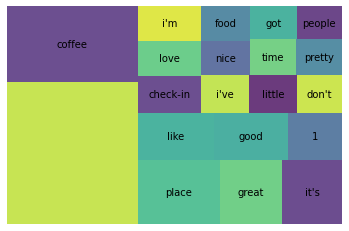

In [92]:
# Visualize top 20 overall words
import squarify
import matplotlib.pyplot as plt

# Count tokens
wc = count(shops['tokens'])

# Get top 20
wc_top20 = wc[wc['rank'] <= 20]

# Plot
squarify.plot(sizes=wc_top20['pct_total'], label=wc_top20['word'], alpha=.8 )
plt.axis('off')
plt.show()

In [93]:
# Extending Stop Words
STOP_WORDS = nlp.Defaults.stop_words.union([' ', 'coffee', 'coffee.', 'shop', "i'm",
                                            'check-in', "i've", '1', "it's", "don't", '-'])

tokens = []
for doc in tokenizer.pipe(shops['full_review_text'], batch_size=500):
    doc_tokens = []
    for token in doc: 
        if token.text.lower() not in STOP_WORDS:
            doc_tokens.append(token.text.lower())
    tokens.append(doc_tokens)
    
shops['tokens'] = tokens
wc = count(shops['tokens'])
wc.head()

,word,count,rank,pct_total
77,place,4264,1.0,0.011477
142,great,3250,2.0,0.008748
185,like,2902,3.0,0.007811
157,good,2779,4.0,0.007480
0,love,1806,5.0,0.004861


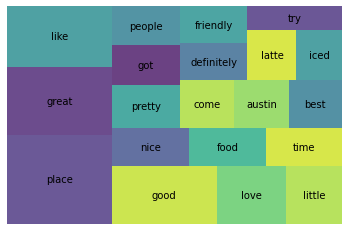

In [94]:
# Visualize again
wc_top20 = wc[wc['rank'] <= 20]

squarify.plot(sizes=wc_top20['pct_total'], label=wc_top20['word'], alpha=.8 )
plt.axis('off')
plt.show()

## View Counts by Rating

In [95]:
# Make a new column 'good_rating'
shops['good_rating'] = [1 if x>=4 else 0 for x in shops['star_rating']]
shops.sample(5)

,coffee_shop_name,full_review_text,star_rating,tokens,good_rating
6801,Teo,Amazing gelato and the folks are pretty friend...,5.0,"[amazing, gelato, folks, pretty, friendly!, la...",1
3488,Patika,2 check-ins Listed in Austin Coffee Patika pre...,5.0,"[2, check-ins, listed, austin, patika, pretty,...",1
2308,Mary’s Cafe,6 check-ins They have catered for our office t...,5.0,"[6, check-ins, catered, office, twice, time, d...",1
2919,Thunderbird Coffee,"Overall, this is a solid coffee shop. If you'r...",3.0,"[overall,, solid, shop., you're, going, coffee...",0
924,Venezia Italian Gelato,Awesome addition to the growing South Lamar fo...,5.0,"[awesome, addition, growing, south, lamar, foo...",1


In [96]:
# Save 'good shops' and 'bad shops' in different dataframes
good_shops = shops[shops['good_rating']==1]
bad_shops = shops[shops['good_rating']==0]
good_shops.shape, bad_shops.shape

((6140, 5), (1476, 5))

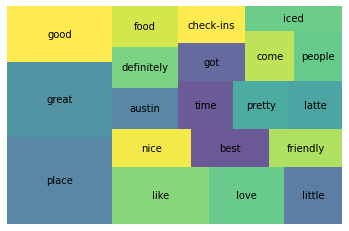

In [97]:
# Visualize top words for 'good shops'
wc = count(good_shops['tokens'])
wc_top20 = wc[wc['rank'] <= 20]
squarify.plot(sizes=wc_top20['pct_total'], label=wc_top20['word'], alpha=.8 )
plt.axis('off')
plt.show()

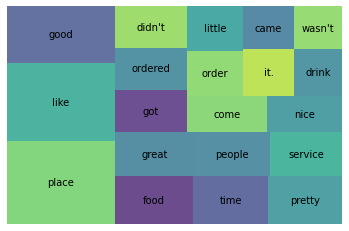

In [98]:
# Visualize top words for 'bad shops'
wc = count(bad_shops['tokens'])
wc_top20 = wc[wc['rank'] <= 20]
squarify.plot(sizes=wc_top20['pct_total'], label=wc_top20['word'], alpha=.8 )
plt.axis('off')
plt.show()

# Lemmatization

In [99]:
# Define a function to get the lemmas
def get_lemmas(text):
    lemmas = []
    doc = nlp(text)
    for token in doc: 
        if ((token.is_stop == False) and (token.is_punct == False)) and (token.pos_ != 'PRON'):
            lemmas.append(token.lemma_)
    return lemmas

In [100]:
# Apply the function
shops['lemmas'] = shops['full_review_text'].apply(get_lemmas)
shops['lemmas'].head()

0    [1, check, Love, love, love, atmosphere, corne...
1    [list, Date, Night, Austin, Ambiance, Austin, ...
2    [1, check, list, Brunch, Spots, love, eclectic...
3    [cool, decor, good, drink, nice, seating,  ,  ...
4    [1, check, locate, Northcross, mall, shopping,...
Name: lemmas, dtype: object

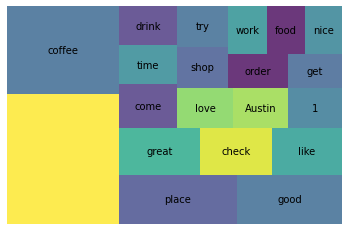

In [101]:
# Visualize the overall top words using lemmatization
wc = count(shops['lemmas'])
wc_top20 = wc[wc['rank'] <= 20]

# The plot
squarify.plot(sizes=wc_top20['pct_total'], label=wc_top20['word'], alpha=.8 )
plt.axis('off')
plt.show()

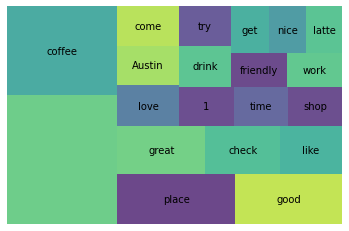

In [102]:
# Visualize top words for 'good shops' using lemmatization
good_shops = shops[shops['good_rating']==1]
wc = count(good_shops['lemmas'])
wc_top20 = wc[wc['rank'] <= 20]

# The plot
squarify.plot(sizes=wc_top20['pct_total'], label=wc_top20['word'], alpha=.8 )
plt.axis('off')
plt.show()

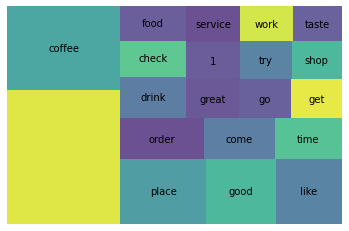

In [103]:
# Visualize top words for 'bad shops' using lemmatization
bad_shops = shops[shops['good_rating']==0]
wc = count(bad_shops['lemmas'])
wc_top20 = wc[wc['rank'] <= 20]

# The plot
squarify.plot(sizes=wc_top20['pct_total'], label=wc_top20['word'], alpha=.8 )
plt.axis('off')
plt.show()

## Can visualize the words with the greatest difference in counts between 'good' & 'bad'?

Couple Notes: 
- Rel. freq. instead of absolute counts b/c of different numbers of reviews
- Only look at the top 5-10 words with the greatest differences


In [104]:
# Get together the words used in good reviews and bad reviews
wc_good = count(good_shops['lemmas'])
wc_bad = count(bad_shops['lemmas'])
wc = pd.merge(wc_good, wc_bad, how='outer', on='word', suffixes=('_good', '_bad'))
wc.head()

,word,count_good,rank_good,pct_total_good,count_bad,rank_bad,pct_total_bad
0,,11626.0,1.0,0.039434,3364.0,1.0,0.040667
1,coffee,8021.0,2.0,0.027207,2110.0,2.0,0.025508
2,place,4804.0,3.0,0.016295,1225.0,3.0,0.014809
3,good,4344.0,4.0,0.014734,1000.0,4.0,0.012089
4,great,3455.0,5.0,0.011719,462.0,12.0,0.005585


In [105]:
# Because of the outer join, there are some missing values
# Replace NaNs with 0
wc = wc.fillna(0)

In [106]:
# Add the column 'difference', and get the absolute value of it
wc['difference'] = abs(wc['pct_total_good'] - wc['pct_total_bad'])
wc = wc.sort_values(by=['difference'], ascending=False)
wc.head()

,word,count_good,rank_good,pct_total_good,count_bad,rank_bad,pct_total_bad,difference
4,great,3455.0,5.0,0.011719,462.0,12.0,0.005585,0.006134
21,order,1370.0,22.0,0.004647,759.0,6.0,0.009176,0.004529
7,love,2069.0,8.0,0.007018,245.0,41.0,0.002962,0.004056
5,check,2942.0,6.0,0.009979,526.0,10.0,0.006359,0.003620
8,Austin,1988.0,9.0,0.006743,288.0,32.0,0.003482,0.003261


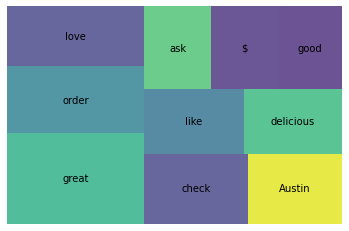

In [107]:
# Save the top 10 greatest differences
wc_top10_diff = wc.head(n=10)

# Visualize
squarify.plot(sizes=wc_top10_diff['difference'], label=wc_top10_diff['word'], alpha=.8 )
plt.axis('off')
plt.show()

## Stretch Goals

* Analyze another corpus of documents - such as Indeed.com job listings ;).
* Play with the Spacy API to
 - Extract Named Entities
 - Extracting 'noun chunks'
 - Attempt Document Classification with just Spacy
 - *Note:* This [course](https://course.spacy.io/) will be of interesting in helping you with these stretch goals. 
* Try to build a plotly dash app with your text data 

